In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import numpy as np
import os
import matplotlib.pyplot as plt

In [45]:
# Configuración global
IMG_SIZE = 128
LATENT_DIM = 32
CLASSES = ["0", "1", "2", "3"]
NUM_CLASSES = len(CLASSES)
EMBEDDING_DIM = 128

In [46]:
# --- Placeholder para el Encoder  ---
def build_medical_encoder():
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = layers.Conv2D(64, 3, activation="swish", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, activation="swish", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(256, 3, activation="swish", padding="same")(x)
    x = layers.GlobalAvgPool2D()(x)

    outputs = layers.Dense(LATENT_DIM)(x)

    return keras.Model(inputs, outputs, name="medical_encoder")

In [54]:
# --- Modelo de Difusión ---
class AlzheimerDiffusionModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.embedding_dim = 128 # Definir dimensión del embedding

        # Componentes de condición
        self.class_embedding = layers.Embedding(NUM_CLASSES, self.embedding_dim)
        # La proyección ahora toma el latente (LATENT_DIM) y lo proyecta
        self.source_projection = layers.Dense(self.embedding_dim)

        # U-Net adaptado - La entrada ahora tendrá 3 (img) + 2*embedding_dim (cond) canales
        unet_input_channels = 3 + 2 * self.embedding_dim
        # Ajustar la primera capa Conv2D para manejar los canales de entrada correctos
        self.unet_input_conv = layers.Conv2D(128, 3, activation="swish", padding="same")

        self.unet_blocks = [
            layers.Conv2D(128, 3, activation="swish", padding="same"),
            layers.Conv2D(256, 3, activation="swish", padding="same", strides=2),
            layers.Conv2D(512, 3, activation="swish", padding="same", strides=2),
            layers.UpSampling2D(2),
            layers.Conv2D(256, 3, activation="swish", padding="same"),
            layers.UpSampling2D(2),
            layers.Conv2D(128, 3, activation="swish", padding="same"),
        ]
        self.unet_output_conv = layers.Conv2D(3, 3, padding="same") # Salida de 3 canales (ruido)

    def call(self, inputs):
        noised_images, source_latent, class_info = inputs

        # Procesar condición de clase
        # Si class_info es entero -> es una etiqueta -> aplicar embedding
        # Si class_info es flotante -> es un embedding precalculado -> usar directamente
        if class_info.dtype == tf.int32 or class_info.dtype == tf.int64 :
             # Asegurarse de que class_info tenga rango 1 para el embedding
             if tf.rank(class_info) == 0:
                 class_info = tf.expand_dims(class_info, axis=0)
             # Si el batch size es > 1 y class_info tiene shape (batch_size,)
             # la salida de embedding será (batch_size, embedding_dim)
             class_cond = self.class_embedding(class_info) # (batch_size, embedding_dim)
        else:
             # Asumimos que es un embedding precalculado con shape (batch_size, embedding_dim)
             class_cond = class_info

        # Asegurar que class_cond tenga la misma dimensión de batch que source_latent
        if tf.shape(class_cond)[0] != tf.shape(source_latent)[0] and tf.shape(source_latent)[0] > 1 :
             # Por ahora, asumimos que en generación batch_size=1 y en entrenamiento coinciden
             pass # O manejar la posible discrepancia aquí si es necesario


        # Procesar condición de imagen fuente (latente)
        # source_latent ya tiene shape (batch_size, LATENT_DIM)
        source_cond = self.source_projection(source_latent) # (batch_size, embedding_dim)

        # Combinar condiciones
        combined_cond = tf.concat([class_cond, source_cond], axis=-1) # (batch_size, 2 * embedding_dim)

        # Expandir condición espacialmente
        # combined_cond tiene shape (batch_size, 2 * embedding_dim)
        # Necesitamos (batch_size, 1, 1, 2 * embedding_dim) para hacer tile
        cond = combined_cond[:, tf.newaxis, tf.newaxis, :]
        cond = tf.tile(cond, [1, IMG_SIZE, IMG_SIZE, 1]) # (batch_size, 128, 128, 2 * embedding_dim)

        # Concatenar imagen ruidosa con condición
        # noised_images: (batch_size, 128, 128, 3)
        # cond:          (batch_size, 128, 128, 2 * embedding_dim)
        x = tf.concat([noised_images, cond], axis=-1) # (batch_size, 128, 128, 3 + 2 * embedding_dim)

        # Pasar por la U-Net
        x = self.unet_input_conv(x) # Ajusta canales
        for block in self.unet_blocks:
            x = block(x)
        output = self.unet_output_conv(x) # Predicción del ruido

        return output

        def build(self, input_shape):
          super().build(input_shape)


# --- Generador de Progresión ---
class AlzheimerProgressionGenerator:
    def __init__(self, encoder, diffusion_model, diffusion_steps=1000):
        self.encoder = encoder
        self.diffusion_model = diffusion_model
        self.diffusion_steps = diffusion_steps

        # Calcular betas, alphas, alpha_bars (Usando linspace como en el original por simplicidad)
        betas = tf.linspace(1e-4, 0.02, self.diffusion_steps)
        self.alphas = 1.0 - betas
        self.alpha_bars = tf.math.cumprod(self.alphas)
        # Asegurar que sean float32
        self.alphas = tf.cast(self.alphas, tf.float32)
        self.alpha_bars = tf.cast(self.alpha_bars, tf.float32)


    def encode_source(self, source_images):
        # Asegurar que la entrada sea float32
        source_images = tf.cast(source_images, tf.float32)
        return self.encoder(source_images) # Shape: (batch_size, LATENT_DIM)

    def generate_progression(self, source_latent, start_class, end_class, steps=50):
        batch_size = tf.shape(source_latent)[0] # Obtener batch_size del latente
        if batch_size != 1:
             print("Advertencia: La generación está implementada para batch_size=1.")

        # Obtener embeddings de las clases de inicio y fin
        # Asegurar que las clases sean tensores int32 y tengan la dimensión de batch
        start_class_tensor = tf.cast(tf.fill((batch_size,), start_class), dtype=tf.int32)
        end_class_tensor = tf.cast(tf.fill((batch_size,), end_class), dtype=tf.int32)

        start_emb = self.diffusion_model.class_embedding(start_class_tensor) # (batch_size, embedding_dim)
        end_emb = self.diffusion_model.class_embedding(end_class_tensor)     # (batch_size, embedding_dim)

        # Configurar pasos de difusión para la generación (sampling)
        step_size = self.diffusion_steps // steps
        timesteps = tf.range(self.diffusion_steps - 1, 0, -step_size)

        # Inicializar con ruido Gaussiano
        x_t = tf.random.normal(shape=(batch_size, IMG_SIZE, IMG_SIZE, 3))

        generated_images = []
        for i, t_int in enumerate(timesteps):
            t = tf.cast(t_int, tf.int32) # Tiempo actual como entero
            t_batch = tf.fill((batch_size,), t) # Crear tensor de tiempo para el batch

            # Mezcla dinámica de embeddings de condición de clase
            # Usar i (índice del bucle de sampling) para la interpolación, no t
            mix_factor = tf.cast(i / (len(timesteps) -1 ), tf.float32) if len(timesteps)>1 else 1.0 # Normalizado entre 0 y 1
            mix_factor = tf.reshape(mix_factor, (1, 1)) # Asegurar broadcasting (1, 1)

            current_class_emb = (1.0 - mix_factor) * start_emb + mix_factor * end_emb # Interpolar embeddings (batch_size, embedding_dim)

            # Predecir ruido usando el modelo
            # El modelo ahora espera (imagen_ruidosa, latente_fuente, embedding_clase)
            noise_pred = self.diffusion_model([x_t, source_latent, current_class_emb]) # Pasa el embedding interpolado

            # Paso de Denoising (Algoritmo DDPM)
            alpha_t = tf.gather(self.alphas, t_batch)[:, tf.newaxis, tf.newaxis, tf.newaxis]
            alpha_bar_t = tf.gather(self.alpha_bars, t_batch)[:, tf.newaxis, tf.newaxis, tf.newaxis]
            alpha_bar_t_prev = tf.gather(self.alpha_bars, t_batch - 1)[:, tf.newaxis, tf.newaxis, tf.newaxis] # t-1
            beta_t = 1.0 - alpha_t

            # Calcular la media de la posterior q(x_{t-1} | x_t, x_0)
            # Estimación de x_0 desde x_t y noise_pred
            x_0_pred = (x_t - tf.sqrt(1.0 - alpha_bar_t) * noise_pred) / tf.sqrt(alpha_bar_t)
            x_0_pred = tf.clip_by_value(x_0_pred, -1.0, 1.0) # Clip x0 (importante si normalizas a [-1, 1]) o [0, 1]

            # Calcular coeficientes para la media
            mean_coeff1 = tf.sqrt(alpha_bar_t_prev) * beta_t / (1.0 - alpha_bar_t)
            mean_coeff2 = tf.sqrt(alpha_t) * (1.0 - alpha_bar_t_prev) / (1.0 - alpha_bar_t)

            # Media del paso de denoising
            x_t_minus_1_mean = mean_coeff1 * x_0_pred + mean_coeff2 * x_t

            # Calcular la varianza (usamos beta_t 'tilde')
            beta_t_tilde = beta_t * (1.0 - alpha_bar_t_prev) / (1.0 - alpha_bar_t)

            # Añadir ruido si t > 0
            noise = tf.random.normal(shape=tf.shape(x_t))
            # Asegurar de que la varianza no sea negativa (puede pasar por errores numéricos)
            variance = tf.maximum(beta_t_tilde, 1e-20) # Añadir pequeño epsilon
            x_t_minus_1 = x_t_minus_1_mean + tf.sqrt(variance) * noise * tf.cast(t > 0, tf.float32) # No añadir ruido en el último paso (t=0)

            x_t = x_t_minus_1 # Actualizar x_t para el siguiente paso

            # Guardar imagen generada (cada pocos pasos para visualización)
            # Guardamos x_t que es x_{t-1} en esta iteración
            if i % (len(timesteps) // 5) == 0 or i == len(timesteps) - 1: # Guardar unas 5-6 imágenes
                 # Desnormalizar si es necesario antes de guardar/mostrar
                 img_to_save = (x_t[0] * 255.0) if normalization_layer.scale == 1./255 else (x_t[0] * 127.5 + 127.5) # Ajusta según tu normalización
                 img_to_save = tf.clip_by_value(img_to_save, 0.0, 255.0)
                 generated_images.append(img_to_save)

        return generated_images

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os

# Ruta a tu carpeta específica
ruta_carpeta = '/content/drive/MyDrive/Colab Notebooks/Dataset Alz'

ruta_train = '/content/drive/MyDrive/Colab Notebooks/Dataset Alz/train'


In [27]:
IMG_SIZE = 128
BATCH_SIZE = 32

dataset = tf.keras.utils.image_dataset_from_directory(
    ruta_train,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Opcional: normalizar
normalization_layer = tf.keras.layers.Rescaling(1./255)
dataset = dataset.map(lambda x, y: (normalization_layer(x), y))

Found 10240 files belonging to 4 classes.


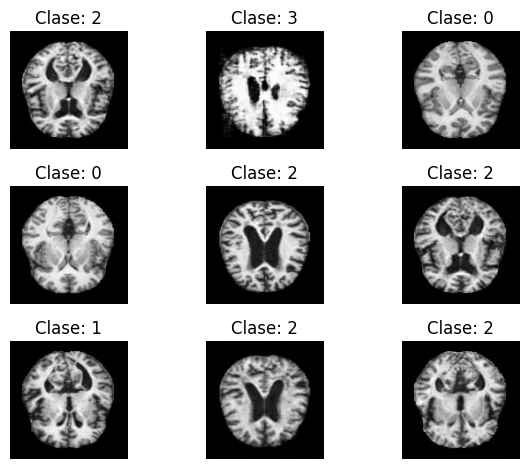

In [8]:
for images, labels in dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy())
        plt.title(f"Clase: {labels[i].numpy()}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [57]:
# Inicializar modelos
encoder = build_medical_encoder()
print("Encoder construido. Sumario:")
encoder.summary()
diffusion_model = AlzheimerDiffusionModel()

# Parámetros de difusión para el entrenamiento
diffusion_steps_train = 1000
betas_train = np.linspace(1e-4, 0.02, diffusion_steps_train)
alphas_train = 1.0 - betas_train
alpha_bars_train = np.cumprod(alphas_train)
alpha_bars_train_tf = tf.constant(alpha_bars_train, dtype=tf.float32)

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

# Función de pérdida
mse = keras.losses.MeanSquaredError()

Encoder construido. Sumario:


Model: "medical_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_113 (Conv2D)             │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_114 (Conv2D)             │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         8,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 379,040 (1.45 MB)

 Trainable params: 379,040 (1.45 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
@tf.function
def train_step(images, labels):
    # Codificar la imagen fuente
    latent = encoder(images, training=False)

    # Seleccionar timesteps al azar
    batch_size = tf.shape(images)[0]
    t = tf.random.uniform((batch_size,), minval=0, maxval=diffusion_steps, dtype=tf.int32)

    # Calcular alpha_bar[t]
    alpha_bar_t = tf.gather(alpha_bars_train_tf, t)
    alpha_bar_t = tf.reshape(alpha_bar_t, (batch_size, 1, 1, 1))

    # Agregar ruido a la imagen
    noise = tf.random.normal(tf.shape(images))
    noised = tf.sqrt(alpha_bar_t) * images + tf.sqrt(1.0 - alpha_bar_t) * noise

    with tf.GradientTape() as tape:
        noise_pred = diffusion_model([noised, latent, labels])
        loss = mse(noise, noise_pred)

    trainable_vars = diffusion_model.trainable_variables + encoder.trainable_variables
    grads = tape.gradient(loss, trainable_vars)
    optimizer.apply_gradients(zip(grads, trainable_vars))
    return loss

# Entrenamiento
EPOCHS = 1
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    progbar = tf.keras.utils.Progbar(target=len(dataset), stateful_metrics=["loss"])
    for step, (images, labels) in enumerate(dataset):
        loss = train_step(images, labels)
        progbar.update(step + 1, [("loss", loss)])

print("--- Entrenamiento Finalizado ---")

Epoch 1/1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:1387: UserWarning: Layer 'alzheimer_diffusion_model_13' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''Using a symbolic `tf.Tensor` as a Python `bool` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function wi

OperatorNotAllowedInGraphError: in user code:

    File "<ipython-input-58-10d0f95858fa>", line 19, in train_step  *
        noise_pred = diffusion_model([noised, latent, labels])
    File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "<ipython-input-54-8b721b9f5948>", line 36, in call
        if tf.rank(class_info) == 0:

    OperatorNotAllowedInGraphError: Exception encountered when calling AlzheimerDiffusionModel.call().
    
    [1mUsing a symbolic `tf.Tensor` as a Python `bool` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.[0m
    
    Arguments received by AlzheimerDiffusionModel.call():
      • inputs=['tf.Tensor(shape=(32, 128, 128, 3), dtype=float32)', 'tf.Tensor(shape=(32, 32), dtype=float32)', 'tf.Tensor(shape=(32,), dtype=int32)']



--- Iniciando Generación de Progresión ---
Imagen cargada con etiqueta: 2


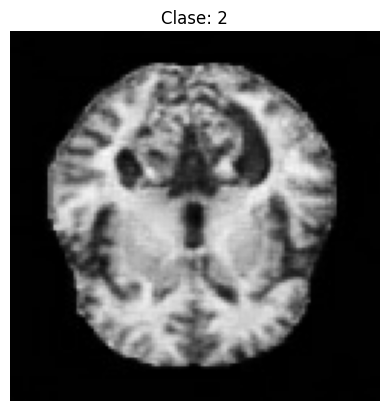

Generando progresión desde clase 0 (0) a clase 3 (3)
Visualizando 6 imágenes generadas...


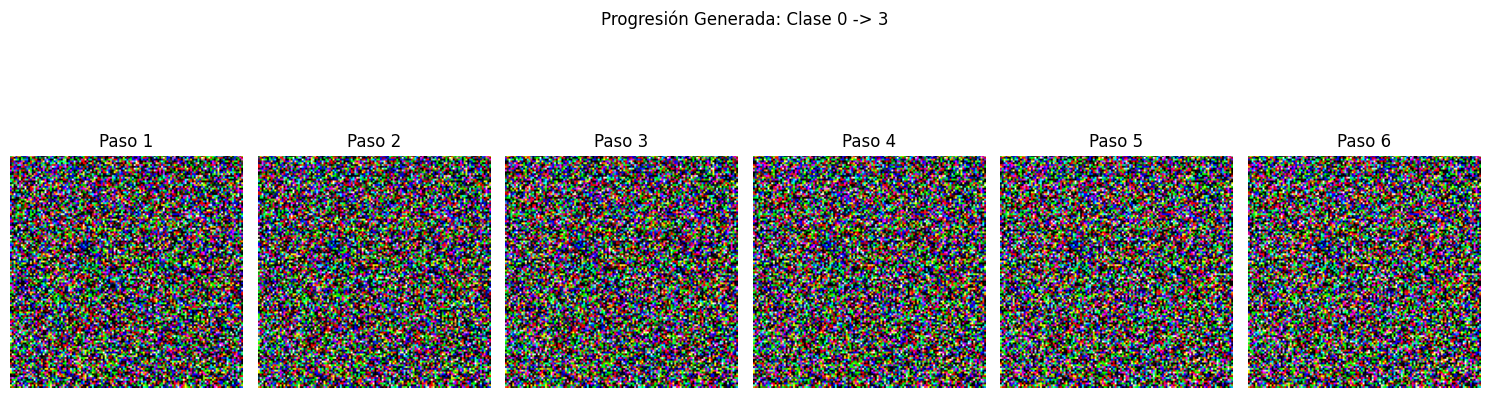

In [59]:
print("\n--- Iniciando Generación de Progresión ---")

progression_generator = AlzheimerProgressionGenerator(encoder, diffusion_model)

# Cargar una imagen de ejemplo del dataset (por ejemplo, la primera imagen del batch)
for images, labels in dataset.take(1):
    image = images[0].numpy()  # Cargar la primera imagen
    label = labels[0].numpy()  # Cargar la etiqueta correspondiente

    # Mostrar la imagen y su etiqueta original
    print(f"Imagen cargada con etiqueta: {label}")
    plt.imshow(image)
    plt.title(f"Clase: {label}")
    plt.axis('off')
    plt.show()

    # Codificar la imagen para obtener la representación latente
    source_latent = progression_generator.encode_source(tf.convert_to_tensor([image]))
    source_tensor = tf.expand_dims(tf.cast(image, tf.float32), axis=0)
    source_latent = progression_generator.encode_source(source_tensor) # Shape (1, LATENT_DIM)
# --- GENERAR PROGRESIÓN ---
start_class_idx = 0  # Índice de la clase "sin deterioro"
end_class_idx = 3    # Índice de la clase "deterioro moderado"
num_generation_steps = 10 # Número de imágenes a generar en la secuencia

print(f"Generando progresión desde clase {start_class_idx} ({CLASSES[start_class_idx]}) a clase {end_class_idx} ({CLASSES[end_class_idx]})")
generated_images = progression_generator.generate_progression(
            source_latent=source_latent,    # (1, LATENT_DIM)
            start_class=start_class_idx,    # Entero
            end_class=end_class_idx,        # Entero
            steps=50                       # Pasos internos del proceso de difusión inversa (sampling)
            )


        # Visualizar las imágenes generadas
print(f"Visualizando {len(generated_images)} imágenes generadas...")
plt.figure(figsize=(15, 5))
num_images_to_show = len(generated_images)
for i, gen_img_tensor in enumerate(generated_images):
  plt.subplot(1, num_images_to_show, i + 1)
  # El tensor ya debería estar desnormalizado y en [0, 255] por el generador
  img_display = np.clip(gen_img_tensor.numpy(), 0, 255).astype(np.uint8)
  plt.imshow(img_display)
  plt.title(f"Paso {i+1}")
  plt.axis('off')
plt.suptitle(f"Progresión Generada: Clase {start_class_idx} -> {end_class_idx}")
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para el supertítulo
plt.show()